# Random Forest
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cha     1206 non-null   int64 
 1   dex     1206 non-null   int64 
 2   ac      1206 non-null   int64 
 3   level   1206 non-null   int64 
 4   book    1206 non-null   object
 5   wis     1206 non-null   int64 
 6   con     1206 non-null   int64 
 7   str     1206 non-null   int64 
 8   int     1206 non-null   int64 
 9   hp      1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,cha,dex,ac,level,book,wis,con,str,int,hp
0,1,2,29,10,Pathfinder Bestiary,2,5,7,1,215
1,1,0,28,10,Pathfinder Bestiary,2,5,9,-4,220
2,-2,3,25,8,Pathfinder Bestiary,3,6,7,-4,175
3,6,4,41,17,Pathfinder Bestiary,5,5,7,6,315
4,1,3,16,1,Pathfinder Bestiary,1,1,-5,-1,20


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


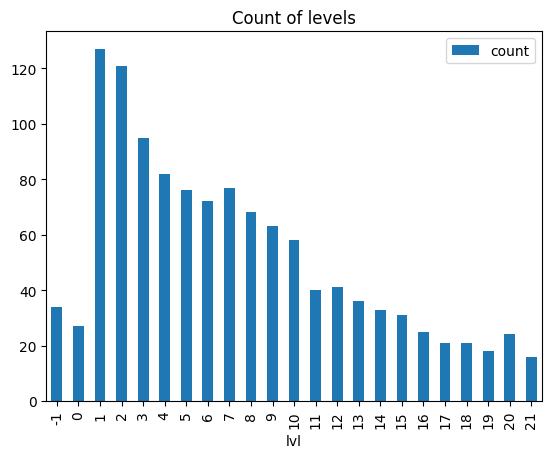

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/random_forest")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [10]:
X_train = X_train.astype("int64")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cha     841 non-null    int64
 1   dex     841 non-null    int64
 2   ac      841 non-null    int64
 3   wis     841 non-null    int64
 4   con     841 non-null    int64
 5   str     841 non-null    int64
 6   int     841 non-null    int64
 7   hp      841 non-null    int64
dtypes: int64(8)
memory usage: 59.1 KB


In [11]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [12]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [13]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

## Chronological split

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [15]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [16]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = median_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 2.23
RMSE: 1.49
MAE: 0.97


In [17]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [18]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 1.22
RMSE test: 1.49


In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.23
RMSE: 1.49

Round type: round
MSE: 2.52
RMSE: 1.59

Round type: 0.33
MSE: 2.16
RMSE: 1.47

Round type: 0.45
MSE: 2.52
RMSE: 1.59



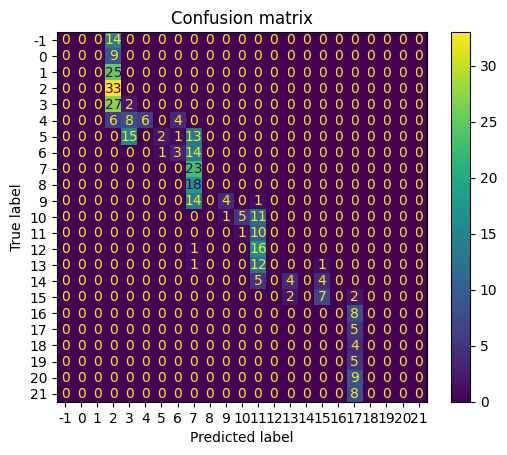

In [20]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [23]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   3.2s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.1s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.9s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.9s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.3s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.9s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [24]:
rmse, mse, mae = assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.17
RMSE test: 0.67
MSE test: 0.45
MAE test: 0.43



In [25]:
results.loc[1] = [
    "chronological",
    "RandomizedSearchCV",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [26]:
predict = rf_random.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.52
RMSE: 0.72

Round type: 0.33
MSE: 0.45
RMSE: 0.67

Round type: 0.45
MSE: 0.50
RMSE: 0.70



### Attempt to decrease overfitting
Change max_depth to 7

In [27]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=100, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
rmse, mse, mae = assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.29
RMSE test: 0.70
MSE test: 0.50
MAE test: 0.46



In [28]:
results.loc[2] = [
    "chronological",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

Check rounded predictions

In [29]:
predict = rf.predict(X_test)

check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.50
RMSE: 0.70

Round type: round
MSE: 0.57
RMSE: 0.76

Round type: 0.33
MSE: 0.46
RMSE: 0.68

Round type: 0.45
MSE: 0.49
RMSE: 0.70



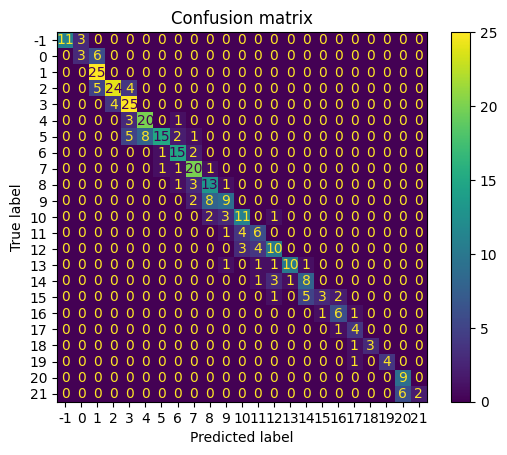

In [30]:
plot_confusion_matrix("round", predict, y_test)

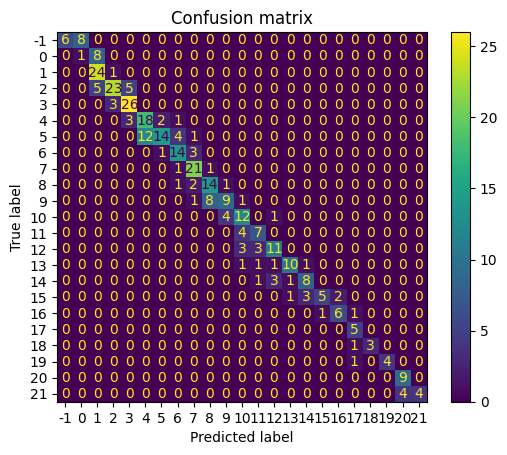

In [31]:
plot_confusion_matrix(0.33, predict, y_test)

The best results for threshold = 0.33

## Random split

In [32]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [33]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [34]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = median_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 1.67
RMSE: 1.29
MAE: 0.92


In [35]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [36]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.67
RMSE: 1.29

Round type: round
MSE: 1.81
RMSE: 1.35

Round type: 0.33
MSE: 1.82
RMSE: 1.35

Round type: 0.45
MSE: 1.82
RMSE: 1.35



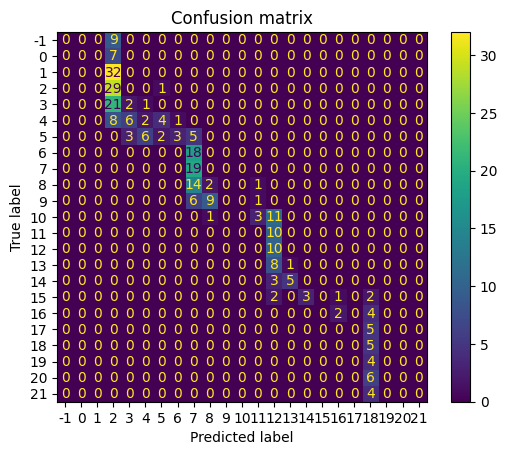

In [37]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [38]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [39]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.7s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.6s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.6s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.2s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.2s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [40]:
rmse, mse, mae = assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.18
RMSE test: 0.48
MSE test: 0.23
MAE test: 0.30



In [41]:
results.loc[4] = ["random", "RandomizedSearchCV", len(X_test.columns), mse, rmse, mae]

### Attempt to decrease overfitting
Change max_depth to 13

In [42]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=200, max_features=0.5, max_depth=13
)
rf.fit(X_train_random_split, y_train_random_split)
rmse, mse, mae = assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.18
RMSE test: 0.49
MSE test: 0.24
MAE test: 0.31



In [43]:
results.loc[5] = [
    "random",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

Check rounded predictions

In [44]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.27
RMSE: 0.52

Round type: 0.33
MSE: 0.31
RMSE: 0.56

Round type: 0.45
MSE: 0.26
RMSE: 0.51



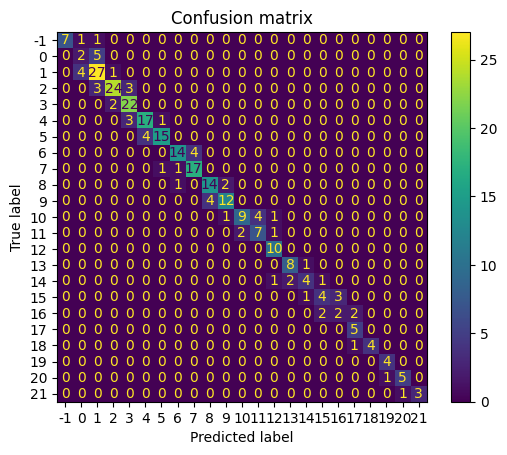

In [45]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

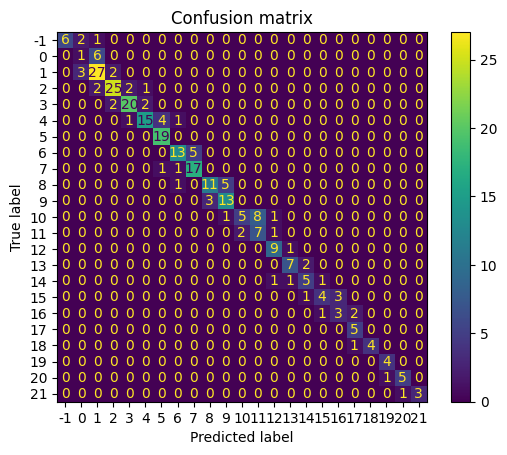

In [46]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)

## Summary

In [47]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,2.232047,1.494004,0.970906
1,chronological,RandomizedSearchCV,8,0.452306,0.672537,0.428295
2,chronological,minimalise_overfitting,8,0.496157,0.704384,0.460843
3,random,normal,8,1.671128,1.292721,0.919120
4,random,RandomizedSearchCV,8,0.227646,0.477122,0.299321
5,random,minimalise_overfitting,8,0.239155,0.489034,0.307780


In [48]:
from training.results import plot_summary

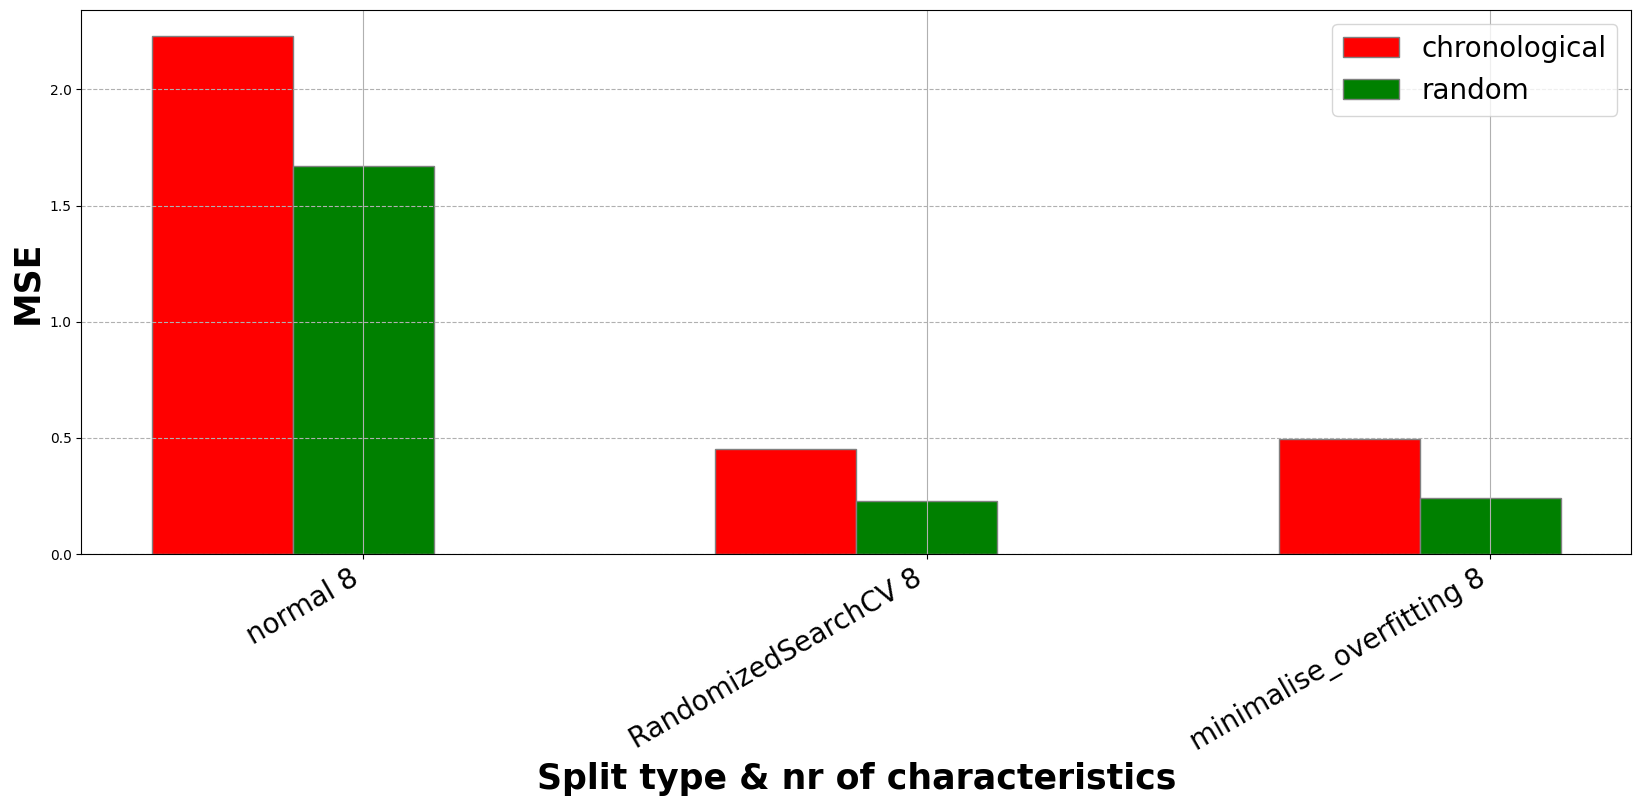

In [49]:
plot_summary(results, "MSE")

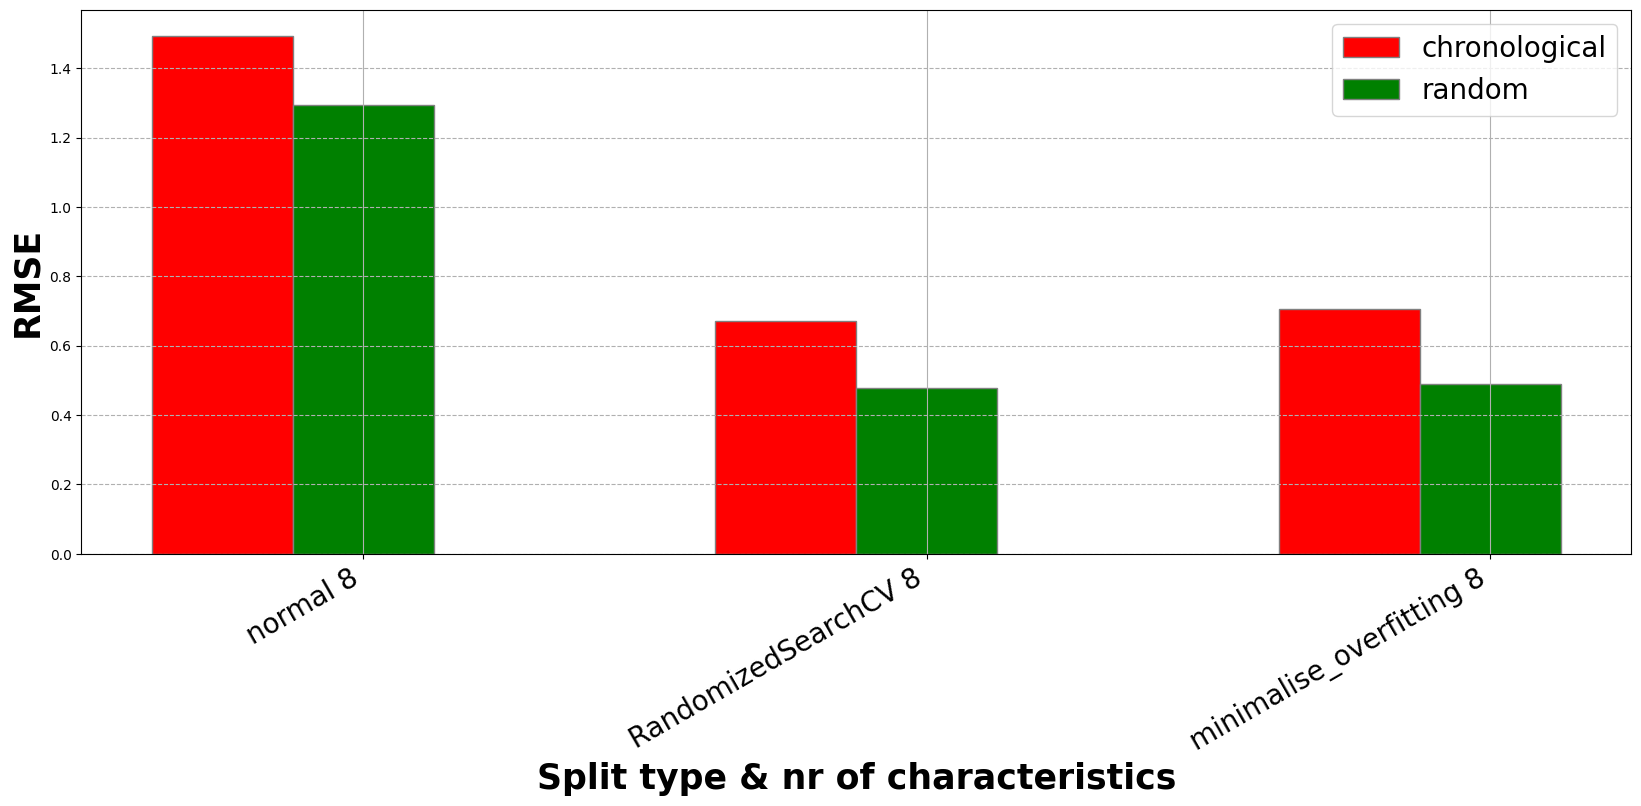

In [50]:
plot_summary(results, "RMSE")

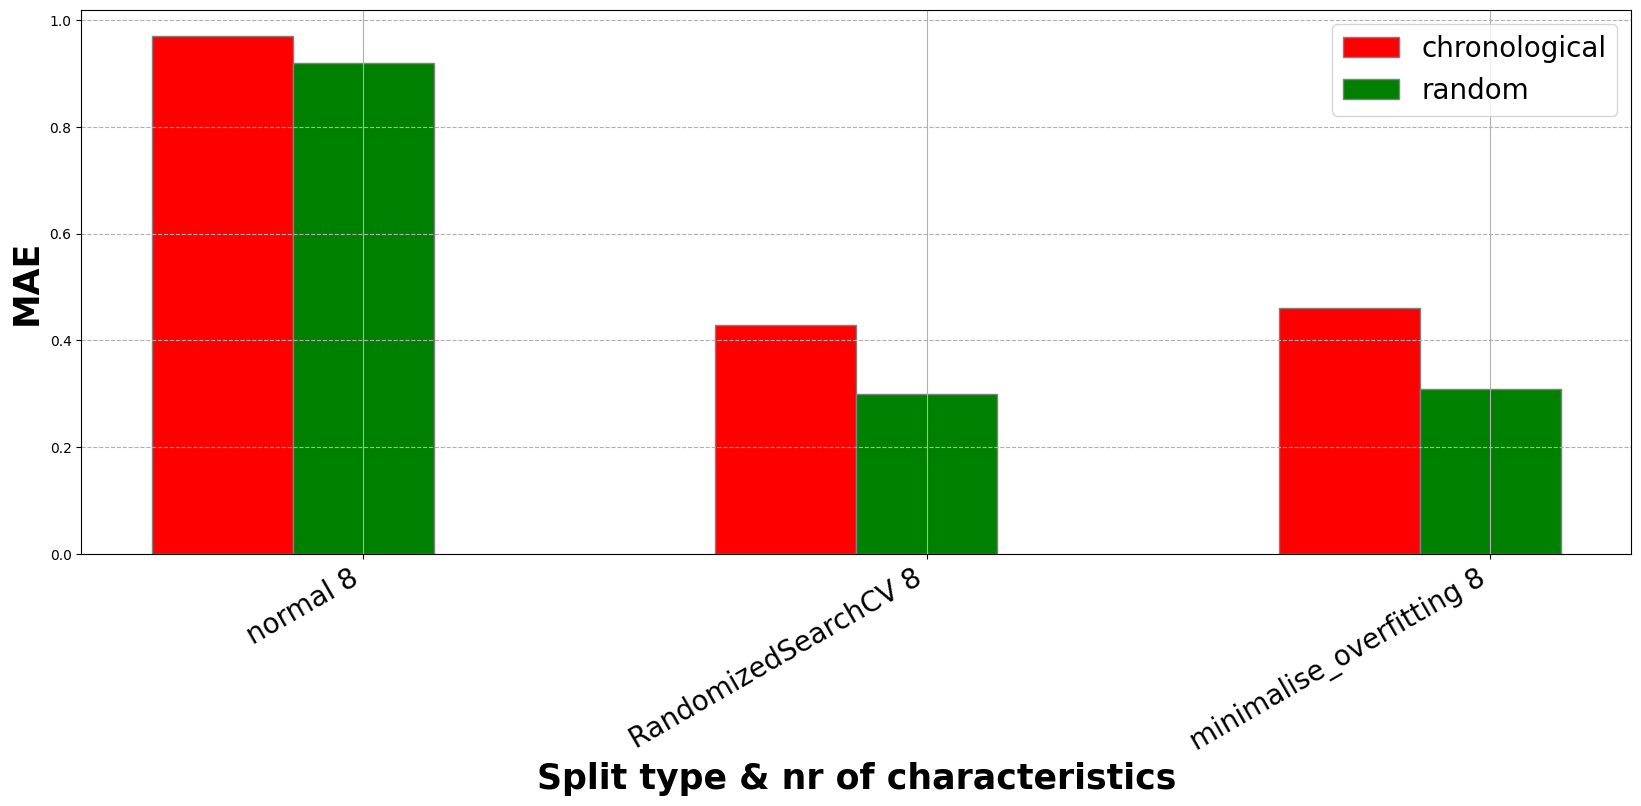

In [52]:
plot_summary(results, "MAE")

In [51]:
results.to_json("./random_forest_basic_results.json")